In [14]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from datetime import datetime
from typing import Tuple
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, make_scorer, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from scipy.stats import uniform, beta, gamma

from data_retriever import DataRetriever
from data_preprocessor import DataPreprocessor
from metrics import r_squared, rmse, nrmse, mape, smape
from adstock import Adstock
from saturation import Saturation
from visualization import attribution_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Config
PATH_TO_DB = './data.db'
TARGET = 'revenue'
MEDIA_VARIABLES = [
    'tv_S', 
    'ooh_S', 
    'print_S', 
    'search_S', 
    'facebook_S', 
    'newsletter'
]
CONTROL_VARIABLES = (
    ['competitor_sales_B', 'event1', 'event2']
    # ['event1', 'event2']
)

In [16]:
# Data 
dr = DataRetriever(
    db=PATH_TO_DB,
    start_dt=datetime.fromisoformat('2015-11-23'),
    end_dt=datetime.fromisoformat('2019-11-11')
)
data = dr.retrieve()

In [17]:
# Preprocessing
dp = DataPreprocessor(data, MEDIA_VARIABLES, CONTROL_VARIABLES, TARGET)
X, y = dp.compute_X_y()

In [18]:
# Train and Test
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=0, 
    shuffle=False, 
    test_size=0.2
)

In [19]:
# Model
model = {
    'estimator': Ridge(
        fit_intercept = False,
        positive=True,
    ), 
    'param_distributions': dict(
        adstock__adstock__theta = beta(a=2, b=5),
        saturation__saturation__col_0_a = gamma(a=3),
        saturation__saturation__col_0_b = beta(a=2, b=2),
        saturation__saturation__col_1_a = gamma(a=3),
        saturation__saturation__col_1_b = beta(a=2, b=2),
        saturation__saturation__col_2_a = gamma(a=3),
        saturation__saturation__col_2_b = beta(a=2, b=2),
        saturation__saturation__col_3_a = gamma(a=3),
        saturation__saturation__col_3_b = beta(a=2, b=2),
        saturation__saturation__col_4_a = gamma(a=3),
        saturation__saturation__col_4_b = beta(a=2, b=2),
        saturation__saturation__col_5_a = gamma(a=3),
        saturation__saturation__col_5_b = beta(a=2, b=2),
        estimator__alpha = [0.01, 0.1, 1, 2, 4, 8, 10, 10**2, 10**3],
    )
}

In [20]:
# Fitting
estimator = model['estimator']
param_distributions = model['param_distributions']
scoring = make_scorer(mean_absolute_error, greater_is_better=False)
adstock = ColumnTransformer([
        ('adstock', Adstock(), [0, 1, 2, 3, 4, 5]),
        ], 
        remainder='passthrough'
)
saturation = ColumnTransformer([
        ('saturation', Saturation(), [0, 1, 2, 3, 4, 5]),
        ], 
        remainder='passthrough'
)
pipe = Pipeline([
    ('adstock', adstock), 
    ('scaler', MinMaxScaler(clip=True)), 
    ('saturation', saturation),
    ('estimator', estimator)
])
tscv = TimeSeriesSplit(n_splits=4)
reg = RandomizedSearchCV(
    estimator=pipe, 
    cv=tscv,
    param_distributions=param_distributions, 
    scoring=scoring, 
    random_state=0,
    n_iter=200
)
search = reg.fit(X_train, y_train)

In [21]:
# Performance metrics
performance_metrics = []
y_test_hat = search.predict(X_test)
metrics_test = {
    'model': f'{estimator.__class__.__name__}',
    'dataset': 'test',
    'r_squared': r_squared(y_test, y_test_hat),
    'rmse': rmse(y_test, y_test_hat),
    'nrmse': nrmse(y_test, y_test_hat),
    'mape': mape(y_test, y_test_hat),
    'smape': smape(y_test, y_test_hat),
}
performance_metrics.append(metrics_test)
y_train_hat = search.predict(X_train)
metrics_train = {
    'model': f'{estimator.__class__.__name__}',
    'dataset': 'train',
    'r_squared': r_squared(y_train, y_train_hat),
    'rmse': rmse(y_train, y_train_hat),
    'nrmse': nrmse(y_train, y_train_hat),
    'mape': mape(y_train, y_train_hat),
    'smape': smape(y_train, y_train_hat),
}
performance_metrics.append(metrics_train)
performance_metrics = pd.DataFrame(performance_metrics)
performance_metrics

,model,dataset,r_squared,rmse,nrmse,mape,smape
0,Ridge,test,0.817444,278833.864974,0.133061,0.095042,0.114591
1,Ridge,train,0.830319,296290.745304,0.095569,0.090513,0.103819


In [22]:
search.best_params_

{'adstock__adstock__theta': 0.2871966671169291,
 'estimator__alpha': 0.1,
 'saturation__saturation__col_0_a': 1.1576345073484013,
 'saturation__saturation__col_0_b': 0.43797296890780374,
 'saturation__saturation__col_1_a': 3.1910513824471947,
 'saturation__saturation__col_1_b': 0.36824474195404894,
 'saturation__saturation__col_2_a': 1.6792127370509666,
 'saturation__saturation__col_2_b': 0.5853765031893802,
 'saturation__saturation__col_3_a': 4.783689666754019,
 'saturation__saturation__col_3_b': 0.013216546264694993,
 'saturation__saturation__col_4_a': 4.102355972987409,
 'saturation__saturation__col_4_b': 0.2103577924288065,
 'saturation__saturation__col_5_a': 5.432874786778585,
 'saturation__saturation__col_5_b': 0.43561693600276014}

In [23]:
saturation_best_params = {
    k.replace('saturation__saturation__', ''):search.best_params_[k] 
    for k in search.best_params_.keys() if k.startswith('saturation__')
}

In [24]:
coefficients = {
    k:v for k,v in zip(X_train.columns.tolist(), search.best_estimator_['estimator'].coef_.tolist())
}
coefficients

{'tv_S': 731544.7648888156,
 'ooh_S': 97230.6547715695,
 'print_S': 369422.83176365163,
 'search_S': 639455.8954936165,
 'facebook_S': 156644.74576835227,
 'newsletter': 105996.16782611316,
 'competitor_sales_B': 2288901.14234112,
 'event1': 2062669.0575861249,
 'event2': 0.0}

In [25]:
# Attribution
params = saturation_best_params
variables = MEDIA_VARIABLES + CONTROL_VARIABLES
intercept = False

attribution_df = X_test.copy()

adstock = Adstock(theta=search.best_params_['adstock__adstock__theta'])
adstock.fit(X_train[MEDIA_VARIABLES])
attribution_df[MEDIA_VARIABLES] = adstock.transform(X_test[MEDIA_VARIABLES])

scaler = MinMaxScaler()
scaler.fit(attribution_df)
attribution_df = pd.DataFrame(scaler.transform(attribution_df), columns=attribution_df.columns, index=attribution_df.index)

saturation = Saturation(**saturation_best_params)
saturation.fit(attribution_df[MEDIA_VARIABLES])
attribution_df[MEDIA_VARIABLES] = saturation.transform(attribution_df[MEDIA_VARIABLES].values)

for var in variables:
    attribution_df[var] = coefficients[var] * attribution_df[var]

attribution_df["intercept"] = search.best_estimator_['estimator'].intercept_
organic_columns = CONTROL_VARIABLES+['intercept']
attribution_df['organic'] = attribution_df[organic_columns].sum(axis=1)
attribution_df.drop(organic_columns, axis=1, inplace=True)

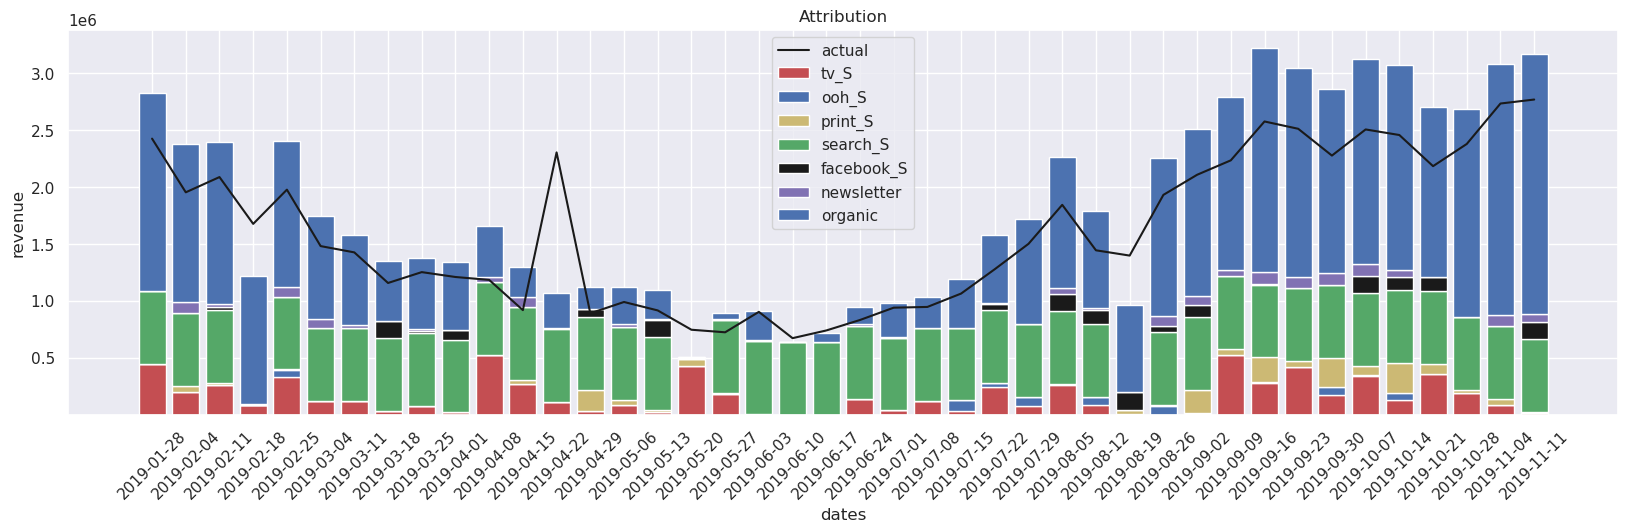

In [26]:
# Plot
attribution_plot(
    attribution_df, 
    TARGET, 
    data.loc[data.index.isin(attribution_df.index), 'revenue']
)